<a href="https://colab.research.google.com/github/jana-jovicic/Genetic-algorithm-for-p-median-problem/blob/master/Solving_p_median_problem_using_PuLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rešavanje p-median problema pomoću PuLP paketa i GLPK rešavača

PuLP omogućuje opisivanje optimizacionih problema kao matematičkih modela, a zatim pozivanje različitih rešavača kao što su GLPK, CPLEX, Gurobi...

Funkcije iz ove sveske služe čisto za proveru rezultata genetskog algoritma i za poređenje vremena potrebnog za dostizanje globalnog optimalnog rešenja i vremena potrebnog za dostizanje zadovoljavajućeg rešenja pomoću genetskog algoritma. Kod je uzet iz priloženog rada.

In [ ]:
!pip install pulp

     |████████████████████████████████| 40.6MB 93kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for amply: filename=amply-0.1.2-cp36-none-any.whl size=16572 sha256=359e62d5fa503e874e66d82aa51f225df3be42f90b3ba992f5158194afd3b82a
  Stored in directory: /root/.cache/pip/wheels/84/18/f7/e5c3ed13ed5bb721763f77d4a924331d59ef115ce61c9d26eb
Successfully built amply


In [ ]:
!apt-get install glpk-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev default-libmysqlclient-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 35 not upgraded.
Need to get 692 kB of archives.
After this operation, 1,664 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsuitesparseconfig5 amd64 1:5.1.2-2 [9,044 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libamd2 amd64 1:5.1.2-2 [19.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libcolamd2 amd64 1:5.1.2-2 [16.2 kB]
Get:4 http://archive.ubuntu.com/ub

In [ ]:
!unzip OR-Library.zip

Archive:  OR-Library.zip
   creating: OR-Library/
  inflating: OR-Library/pmed9.txt    
  inflating: OR-Library/pmed8.txt    
  inflating: OR-Library/pmed7.txt    
  inflating: OR-Library/pmed6.txt    
  inflating: OR-Library/pmed5.txt    
  inflating: OR-Library/pmed4.txt    
  inflating: OR-Library/pmed3.txt    
  inflating: OR-Library/pmed2.txt    
  inflating: OR-Library/pmed15.txt   
  inflating: OR-Library/pmed14.txt   
  inflating: OR-Library/pmed13.txt   
  inflating: OR-Library/pmed12.txt   
  inflating: OR-Library/pmed11.txt   
  inflating: OR-Library/pmed10.txt   
  inflating: OR-Library/pmed1.txt    


In [ ]:
!unzip Lorena\ dataset.zip

Archive:  Lorena dataset.zip
   creating: Lorena dataset/
  inflating: Lorena dataset/pmedian818.txt  
  inflating: Lorena dataset/pmedian3282.txt  
  inflating: Lorena dataset/pmedian324.txt  


In [ ]:
from pulp import *
import numpy as np
import time
from matplotlib import pyplot as plt
from IPython import display

In [ ]:
def read_ORLibrary_input_file(file_path):
    """ 
    Reads data from OR-Library file and creates cost matrix.
    http://people.brunel.ac.uk/~mastjjb/jeb/orlib/pmedinfo.html

    The format of these data files is:
    First line: number of vertices, number of edges, p
    Other lines: the end vertices and the cost of the edge
    """
    
    try:
        with open(file_path, "r") as f:
            first_line = f.readline().strip().split(' ')
            num_vertices = int(first_line[0])
            num_edges = int(first_line[1])
            p = int(first_line[2])
            
            cost_matrix = np.matrix(np.ones((num_vertices, num_vertices)) * np.inf)
            
            for line in f:
                line = line.strip().split(' ')  
                cost_matrix[int(line[0])-1, int(line[1])-1] = int(line[2])
                cost_matrix[int(line[1])-1, int(line[0])-1] = int(line[2])
        
            for i in range(0, num_vertices):
                cost_matrix[i, i] = 0
               
            # Floyd–Warshall algorithm for shortest path
            # https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm
            for k in range(0, num_vertices):
                for i in range(0, num_vertices):
                    for j in range(0, num_vertices):
                        if cost_matrix[i,j] > cost_matrix[i,k] + cost_matrix[k,j]: 
                            cost_matrix[i,j] = cost_matrix[i,k] + cost_matrix[k,j]
                        
        
            return num_vertices, p, cost_matrix
        
    except IOError:
        return None
    

In [ ]:
def euclidean_distance(x1, x2, y1, y2):
  return int(np.sqrt((x1-x2)**2) + (y1-y2)**2)


def read_Lorena_input_file(file_path):
    """
    Reads data from Lorena file and creates cost matrix.
    http://www.lac.inpe.br/~lorena/instancias.html

    The format of these data files is:
    First line: number of vertices, p
    Other lines: X Y  co-ordinates of points. 
    """
    
    try:
        with open(file_path, "r") as f:
            first_line = f.readline().strip().split(' ')
            num_vertices = int(first_line[0])
            p = int(first_line[1])
            
            cost_matrix = np.matrix(np.ones((num_vertices, num_vertices)) * np.inf)
            points = np.empty(shape=(num_vertices, 2))

            i = 0
            for line in f:
                line = line.strip().split(' ')
                points[i, 0] = int(line[0])
                points[i, 1] = int(line[1])
                i +=1 

            for i in range(num_vertices):
              for j in range(i, num_vertices):
                if i != j:
                  cost_matrix[i,j] = euclidean_distance(points[i,0], points[j,0], points[i,1], points[j,1])
                else:
                  cost_matrix[i,j] = 0
                cost_matrix[j,i] = cost_matrix[i,j]

            return num_vertices, p, cost_matrix

    except IOError:
        return None
    

In [ ]:
num_vertices, p, cost_matrix = read_ORLibrary_input_file('OR-Library/pmed3.txt')

In [ ]:
cost_matrix

matrix([[  0.,  77., 139., ..., 114., 105.,  66.],
        [ 77.,   0.,  62., ..., 191., 182., 143.],
        [139.,  62.,   0., ..., 206., 209., 205.],
        ...,
        [114., 191., 206., ...,   0.,   9.,  48.],
        [105., 182., 209., ...,   9.,   0.,  39.],
        [ 66., 143., 205., ...,  48.,  39.,   0.]])

In [ ]:
np.array(cost_matrix[0, :])[0]

array([  0.,  77., 139., 135., 157., 174., 193., 204., 206., 209., 224.,
       157., 132., 111., 125., 168., 179., 215., 253., 220., 152., 233.,
       182.,  91., 114., 163., 224., 128., 153., 170., 188., 178., 169.,
        72.,  71.,  85., 103., 172., 128., 111., 167., 214., 181., 156.,
       138., 189., 189., 156., 203., 120.,  49., 137., 196., 215., 218.,
       208., 183., 180., 106., 141., 227., 190., 172., 149., 101.,  62.,
       105., 162., 170., 180., 238., 176., 127., 169., 253., 191., 196.,
       200., 217., 211., 142., 174., 223., 178.,  96., 194., 287., 200.,
       159., 180., 154., 125., 144., 174., 191., 160., 160., 114., 105.,
        66.])

Od matrice cena se pravi rečnik koji će kao ključeve imati lokacije, a kao vrednosti rečnike kojima je predstavljeno rastojanje od date lokacije do svih ostalih lokacija.

In [ ]:
locations = list(range(num_vertices))
D = dict.fromkeys(locations)
for k in D.keys():
    D[k] = dict(zip(locations, np.array(cost_matrix[k, :])[0]))

In [ ]:
D

{0: {0: 0.0,
  1: 77.0,
  2: 139.0,
  3: 135.0,
  4: 157.0,
  5: 174.0,
  6: 193.0,
  7: 204.0,
  8: 206.0,
  9: 209.0,
  10: 224.0,
  11: 157.0,
  12: 132.0,
  13: 111.0,
  14: 125.0,
  15: 168.0,
  16: 179.0,
  17: 215.0,
  18: 253.0,
  19: 220.0,
  20: 152.0,
  21: 233.0,
  22: 182.0,
  23: 91.0,
  24: 114.0,
  25: 163.0,
  26: 224.0,
  27: 128.0,
  28: 153.0,
  29: 170.0,
  30: 188.0,
  31: 178.0,
  32: 169.0,
  33: 72.0,
  34: 71.0,
  35: 85.0,
  36: 103.0,
  37: 172.0,
  38: 128.0,
  39: 111.0,
  40: 167.0,
  41: 214.0,
  42: 181.0,
  43: 156.0,
  44: 138.0,
  45: 189.0,
  46: 189.0,
  47: 156.0,
  48: 203.0,
  49: 120.0,
  50: 49.0,
  51: 137.0,
  52: 196.0,
  53: 215.0,
  54: 218.0,
  55: 208.0,
  56: 183.0,
  57: 180.0,
  58: 106.0,
  59: 141.0,
  60: 227.0,
  61: 190.0,
  62: 172.0,
  63: 149.0,
  64: 101.0,
  65: 62.0,
  66: 105.0,
  67: 162.0,
  68: 170.0,
  69: 180.0,
  70: 238.0,
  71: 176.0,
  72: 127.0,
  73: 169.0,
  74: 253.0,
  75: 191.0,
  76: 196.0,
  77: 200.0,
  

Sada treba postaviti *decision variables*.
Promenljiva X_loc1_loc2 = 1 označava da je lokacija loc1 (klijent) dodeljena lokaciji loc2 koja je izabrana za medijanu.

In [ ]:
# decision variables
X = LpVariable.dicts('X_%s_%s', (locations,locations), cat = 'Binary', lowBound = 0, upBound = 1)
X

{0: {0: X_0_0,
  1: X_0_1,
  2: X_0_2,
  3: X_0_3,
  4: X_0_4,
  5: X_0_5,
  6: X_0_6,
  7: X_0_7,
  8: X_0_8,
  9: X_0_9,
  10: X_0_10,
  11: X_0_11,
  12: X_0_12,
  13: X_0_13,
  14: X_0_14,
  15: X_0_15,
  16: X_0_16,
  17: X_0_17,
  18: X_0_18,
  19: X_0_19,
  20: X_0_20,
  21: X_0_21,
  22: X_0_22,
  23: X_0_23,
  24: X_0_24,
  25: X_0_25,
  26: X_0_26,
  27: X_0_27,
  28: X_0_28,
  29: X_0_29,
  30: X_0_30,
  31: X_0_31,
  32: X_0_32,
  33: X_0_33,
  34: X_0_34,
  35: X_0_35,
  36: X_0_36,
  37: X_0_37,
  38: X_0_38,
  39: X_0_39,
  40: X_0_40,
  41: X_0_41,
  42: X_0_42,
  43: X_0_43,
  44: X_0_44,
  45: X_0_45,
  46: X_0_46,
  47: X_0_47,
  48: X_0_48,
  49: X_0_49,
  50: X_0_50,
  51: X_0_51,
  52: X_0_52,
  53: X_0_53,
  54: X_0_54,
  55: X_0_55,
  56: X_0_56,
  57: X_0_57,
  58: X_0_58,
  59: X_0_59,
  60: X_0_60,
  61: X_0_61,
  62: X_0_62,
  63: X_0_63,
  64: X_0_64,
  65: X_0_65,
  66: X_0_66,
  67: X_0_67,
  68: X_0_68,
  69: X_0_69,
  70: X_0_70,
  71: X_0_71,
  72: X_0

Kreira se objekat koji predstavlja minimizacioni problem, a zatim mu se dodaju ograničenja i pokreće se njegovo rešavanje:

In [ ]:
start_time = time.time()

prob = LpProblem('PMedian', LpMinimize)

prob += sum(sum(D[i][j] * X[i][j] for j in locations) for i in locations)
prob += sum(X[i][i] for i in locations) == p

for i in locations:
    prob += sum(X[i][j] for j in locations) == 1
    
for i in locations:
    for j in locations:
        prob += X[i][j] <= X[j][j]
        
prob.writeLP('p-median.lp')
#print(prob)

prob.solve(solver = GLPK_CMD())

end_time = time.time()

print('Status: ',LpStatus[prob.status])
print('Objective: ',value(prob.objective))
print('Time: ', end_time-start_time)

Status:  Optimal
Objective:  4250.0
Time:  3.5403707027435303


Sada se prolazi kroz rešenja problema kako bi se izdvojile medijane. Pošto X_loc1_loc2 = 1 označava da je lokacija loc1 (klijent) dodeljena lokaciji loc2, onda ako važi da je loc1 = loc2 (tj. ako lokacija samu sebe opslužuje) to znači da je ta lokacija medijana.

In [ ]:
medians = []

for v in prob.variables():
    if v.varValue == 1:
        id1 = v.name.find('_')
        id2 = v.name.rfind('_')
        first_location = v.name[id1+1:id2]
        second_location = v.name[id2+1:]
        if first_location == second_location:
            medians.append(first_location)
          
        # Da vidimo koji klijenti su dodeljeni kojim resursima
        print(v.name , '=', v.varValue)

X_0_35 = 1.0
X_10_8 = 1.0
X_11_12 = 1.0
X_12_12 = 1.0
X_13_12 = 1.0
X_14_12 = 1.0
X_15_12 = 1.0
X_16_12 = 1.0
X_17_54 = 1.0
X_18_54 = 1.0
X_19_54 = 1.0
X_1_20 = 1.0
X_20_20 = 1.0
X_21_25 = 1.0
X_22_54 = 1.0
X_23_35 = 1.0
X_24_35 = 1.0
X_25_25 = 1.0
X_26_25 = 1.0
X_27_35 = 1.0
X_28_35 = 1.0
X_29_12 = 1.0
X_2_68 = 1.0
X_30_25 = 1.0
X_31_25 = 1.0
X_32_20 = 1.0
X_33_35 = 1.0
X_34_35 = 1.0
X_35_35 = 1.0
X_36_35 = 1.0
X_37_35 = 1.0
X_38_68 = 1.0
X_39_47 = 1.0
X_3_4 = 1.0
X_40_20 = 1.0
X_41_25 = 1.0
X_42_12 = 1.0
X_43_12 = 1.0
X_44_20 = 1.0
X_45_47 = 1.0
X_46_47 = 1.0
X_47_47 = 1.0
X_48_47 = 1.0
X_49_68 = 1.0
X_4_4 = 1.0
X_50_98 = 1.0
X_51_98 = 1.0
X_52_68 = 1.0
X_53_54 = 1.0
X_54_54 = 1.0
X_55_54 = 1.0
X_56_4 = 1.0
X_57_4 = 1.0
X_58_25 = 1.0
X_59_54 = 1.0
X_5_4 = 1.0
X_60_8 = 1.0
X_61_8 = 1.0
X_62_8 = 1.0
X_63_8 = 1.0
X_64_47 = 1.0
X_65_12 = 1.0
X_66_68 = 1.0
X_67_68 = 1.0
X_68_68 = 1.0
X_69_68 = 1.0
X_6_8 = 1.0
X_70_68 = 1.0
X_71_47 = 1.0
X_72_35 = 1.0
X_73_4 = 1.0
X_74_8 = 1.0
X_75_8 = 1.0

In [ ]:
medians

['12', '20', '25', '35', '47', '4', '54', '68', '8', '98']

Prethodni kod, samo stavljen u funkciju:

In [ ]:
def find_solution(num_vertices, p, cost_matrix):
  
  locations = list(range(num_vertices))
  D = dict.fromkeys(locations)
  for k in D.keys():
      D[k] = dict(zip(locations, np.array(cost_matrix[k, :])[0]))
      
  X = LpVariable.dicts('X_%s_%s', (locations,locations), cat = 'Binary', lowBound = 0, upBound = 1)

  start_time = time.time()

  prob = LpProblem('PMedian', LpMinimize)
  prob += sum(sum(D[i][j] * X[i][j] for j in locations) for i in locations)
  prob += sum(X[i][i] for i in locations) == p

  for i in locations:
      prob += sum(X[i][j] for j in locations) == 1
      
  for i in locations:
      for j in locations:
          prob += X[i][j] <= X[j][j]
          
  prob.writeLP('p-median.lp')
  prob.solve(solver = GLPK_CMD())

  end_time = time.time()
  hours, rem = divmod(end_time - start_time, 3600)
  minutes, seconds = divmod(rem, 60)

  print('Status: ',LpStatus[prob.status])
  print('Objective: ',value(prob.objective))
  print('Time: {:0>2}:{:0>2}:{:05.2f}'.format(int(hours), int(minutes), seconds))

  medians = []

  for v in prob.variables():
      if v.varValue == 1:
          id1 = v.name.find('_')
          id2 = v.name.rfind('_')
          first_location = v.name[id1+1:id2]
          second_location = v.name[id2+1:]
          if first_location == second_location:
              medians.append(first_location)

  print(medians)
  return end_time - start_time

In [ ]:
num_vertices, p, cost_matrix = read_ORLibrary_input_file('OR-Library/pmed3.txt')
find_solution(num_vertices, p, cost_matrix)

Status:  Optimal
Objective:  4250.0
Time: 00:00:03.58
['12', '20', '25', '35', '47', '4', '54', '68', '8', '98']


In [ ]:
num_vertices, p, cost_matrix = read_ORLibrary_input_file('OR-Library/pmed15.txt')
find_solution(num_vertices, p, cost_matrix)

Status:  Optimal
Objective:  1729.0
Time: 00:01:04.95
['0', '100', '104', '10', '115', '117', '131', '132', '133', '134', '137', '140', '141', '144', '145', '148', '14', '154', '156', '157', '159', '160', '161', '165', '167', '168', '16', '170', '173', '174', '176', '17', '182', '184', '188', '191', '198', '201', '202', '203', '204', '206', '208', '211', '212', '214', '215', '219', '225', '227', '22', '230', '235', '240', '242', '243', '245', '247', '253', '254', '255', '257', '264', '267', '269', '26', '271', '272', '273', '275', '28', '293', '295', '31', '35', '36', '37', '3', '42', '44', '45', '48', '4', '51', '58', '60', '61', '65', '72', '77', '78', '7', '80', '86', '88', '91', '94', '97', '98', '9']


In [ ]:
num_vertices, p, cost_matrix = read_ORLibrary_input_file('OR-Library/pmed6.txt')
find_solution(num_vertices, p, cost_matrix)

Status:  Optimal
Objective:  7824.0
Time: 00:01:22.05
['100', '110', '125', '15', '85']


In [ ]:
num_vertices, p, cost_matrix = read_Lorena_input_file('Lorena dataset/pmedian324.txt')
find_solution(num_vertices, p, cost_matrix)

Status:  Optimal
Objective:  5571080.0
Time: 00:04:16.84
['143', '198', '199', '247', '73']


In [ ]:
num_vertices, p, cost_matrix = read_Lorena_input_file('Lorena dataset/pmedian818.txt')
find_solution(num_vertices, p, cost_matrix)

Status:  Optimal
Objective:  40329044.0
Time:  9844.806588411331
['125', '198', '322', '584', '688']


### Grafik zavisnosti vremena izvršavanja u odnosu na dimenziju problema

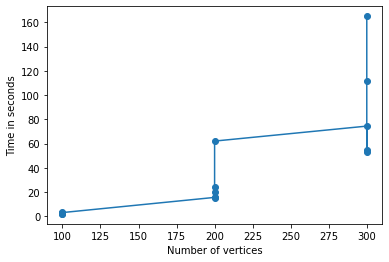

In [ ]:
# OR-Library dataset

vertices_time = []

for f in os.listdir('OR-Library'):
  num_vertices, p, cost_matrix = read_ORLibrary_input_file(os.path.join('OR-Library', f))
  execution_time = find_solution(num_vertices, p, cost_matrix)
  vertices_time.append((num_vertices, execution_time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()


In [ ]:
# Lorena dataset

# Izvrsavanje traje preko 12 sati. Nijednom nije uspelo da se izvrsi do kraja pre nego sto mi se racunar zablokira.

vertices_time = []

for f in os.listdir('Lorena dataset'):
  num_vertices, p, cost_matrix = read_Lorena_input_file(os.path.join('Lorena dataset', f))
  execution_time = find_solution(num_vertices, p, cost_matrix)
  vertices_time.append((num_vertices, execution_time))

display.clear_output(wait=True)

vertices_time_sorted = sorted(vertices_time, key = lambda x: x[0])

plt.plot([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.scatter([x[0] for x in vertices_time_sorted], [x[1] for x in vertices_time_sorted])
plt.ylabel('Time in seconds')
plt.xlabel('Number of vertices')
plt.show()


Status:  Optimal
Objective:  5571080.0
Time: 00:03:18.70
['143', '198', '199', '247', '73']
